### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import datetime
import numpy as np
import scipy.stats as stats
from math import factorial
import seaborn as sns
import plotly.express as px

In [2]:
#создадим переменную с нашим датафреймом
df = pd.read_csv('/content/rest_data.csv')

In [3]:
df.sample(n = 10, random_state = 1)

,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, стро...",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42
5910,28867,школа 775,нет,буфет,"город Москва, Армавирская улица, дом 4",210
10541,187743,24 Градуса,нет,бар,"город Москва, Митинская улица, дом 36",4
14563,217236,Чайхана ОШ,нет,ресторан,"город Москва, проспект Андропова, дом 36",49
10497,182718,ABC Coffee Roasters,нет,кафе,"город Москва, улица Покровка, дом 7/9-11, корп...",15
7708,111069,Кафе Иль Патио «Il Patio»,да,кафе,"город Москва, Каширское шоссе, дом 26",176


In [4]:
#изучим базовую информацию по датафрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
#найдем дубли в датафрейме
df.duplicated().sum()

0

In [6]:
#найдем дубликаты в столбце id
df['id'].duplicated().sum()

0

In [7]:
#изучим столбец с адресами
df['address'].value_counts().head(20)

город Москва, Ходынский бульвар, дом 4                                       95
город Москва, Пресненская набережная, дом 2                                  63
город Москва, проспект Мира, дом 211, корпус 2                               60
город Москва, Кировоградская улица, дом 13А                                  53
город Москва, площадь Киевского Вокзала, дом 2                               48
город Москва, улица Земляной Вал, дом 33                                     46
город Москва, Мытная улица, дом 74                                           46
город Москва, улица Новый Арбат, дом 21                                      42
город Москва, улица Ленинская Слобода, дом 26                                41
город Москва, Кутузовский проспект, дом 57                                   40
город Москва, Ярцевская улица, дом 19                                        40
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10    38
город Москва, Манежная площадь, дом 1, с

In [8]:
#найдем кол-во дублирубщихся адресов
df['address'].duplicated().sum()

6258

In [9]:
#рассмотрим заведения по брендам
df['object_name'].value_counts().head(20)

Столовая                    267
Кафе                        236
Шаурма                      234
KFC                         155
Шоколадница                 142
Бургер Кинг                 122
Макдоналдс                  122
Домино'с Пицца               86
Теремок                      84
Крошка Картошка              82
Пекарня                      76
Милти                        65
Суши Wok                     61
Буфет                        59
СТОЛОВАЯ                     52
Папа Джонс                   50
Школьно-базовая столовая     44
Кофе с собой                 44
Чайхона №1                   42
КАФЕ                         41
Name: object_name, dtype: int64

In [10]:
#проверим на наличие аномалий данные в столбце
df['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [11]:
#проверим типы заведений на уникальность
df['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [12]:
df.duplicated(subset=['object_name', 'chain','object_type','address','number']).sum()

82

In [13]:
df = df.drop_duplicates(subset=['object_name', 'chain','object_type','address','number'])

In [14]:
df

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


##### Первичные выводы:
1. В исследовании представлены 15284 уникальных московских заведения;
2. Заведения могут быть как сетевыми, так и иметь всего 1 точку по городу;  
3. По одному адресу может располагаться множество заведений, яркий пример Ходынский бульвар, дом 4, где представлено 95 точек общественного питания. Всего же в исследовании встречается 6258 заведений, которые соседствуют в одном здании с другими заведениями общепита;  
4. В датафрейме предсталено 82 дубликата, то есть одно и тоже заведение имеет разное ID, их мы не будем учитывать в дальнейшем; 
5. К каждому ресторану относится один из 10 типов: от "кафе" до "магазин (отдел кулинарии)", далее изучим их более детально.

### Анализ данных

#### Исследуем соотношение видов объектов общественного питания по количеству

In [15]:
df_ot = df.pivot_table(index='object_type',values='id',aggfunc='count').reset_index().sort_values(by='id',ascending=False)
df_ot

,object_type,id
3,кафе,6071
8,столовая,2584
7,ресторан,2282
6,предприятие быстрого обслуживания,1898
0,бар,855
1,буфет,577
4,кафетерий,395
2,закусочная,349
5,магазин (отдел кулинарии),273


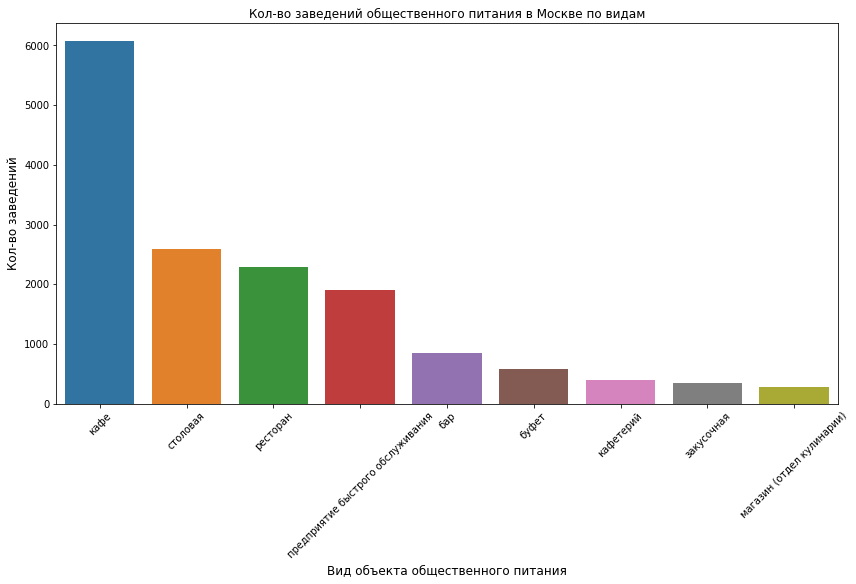

In [16]:
#впосльзуемся бибилотекой seaborn и создадим график, увеличим его размер и записи на стороне x поставим под углом
plt.figure(figsize=(14, 7)) 
ax = sns.barplot(x = 'object_type', y='id',data=df_ot)
ax.set_title('Кол-во заведений общественного питания в Москве по видам',fontsize=12)
ax.set_xlabel('Вид объекта общественного питания',fontsize=12)
ax.set_ylabel('Кол-во заведений',fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

##### Выводы:
1. В Москве больше всего заведений общественного питания по типу "Кафе"(6071), что обусловлено высоким темпом жизни в городской среде и большим кол-вом туристов. В кафе можно относительно быстро пообедать по демократичным ценам и в красивой атмосфере;
2. На втором месте "Столовая"(2584) и почти на том же уровне "Ресторан"(2282). Столовая пользуется такой поппулярностью, так как в городе много студентов, которым не по карману ежедневно ходить в кафе или рестораны. А вот обилие ресторанов обусловлено тем, что Москва-столица и крупный мегаполис, где хочется найти уединение в заведении с качественным сервисом и интересной кулинарией;
3. На четвертом месте по поппулярности располагаются "Предприятия быстрого обуслуживания"(1898). Их распространенность обусловлена все теми же параметром, что и кафе - быстрый городкий ритм. В первом же значительно ниже средний чек;
4. Все прочие типы: "Бар","буфет","кафетерий","закусочная","магазин(отдел кулинарии)" имет менее 1000 заведений в Москве.

#### Исследуем соотношение сетевых и несетевых заведений по количеству

In [17]:
#создадим сводную таблицу и переименуем столбцы для большей понятности
df_c = df.pivot_table(index='chain',values='id',aggfunc='count').reset_index()
df_c['chain'] = df_c['chain'].replace('да','сетевые')
df_c['chain'] = df_c['chain'].replace('нет','уникальные')
df_c

,chain,id
0,сетевые,2964
1,уникальные,12320


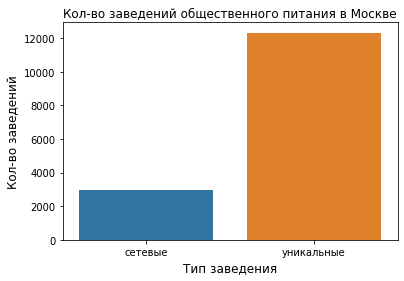

In [18]:
ax = sns.barplot(x = 'chain', y='id',data=df_c)
ax.set_title('Кол-во заведений общественного питания в Москве',fontsize=12)
ax.set_xlabel('Тип заведения',fontsize=12)
ax.set_ylabel('Кол-во заведений',fontsize=12)
plt.show()

##### Выводы:
В Москве  12320 уникальных заведений общественного питания и 2964 точек относится к сетевым*.  
  *Корректно посчитать кол-во сетей невозможно простыми методами,так как в датасете представители одной сети могут иметь разные имена, как например Макдональдс и Кафе "Макдональдс"; кроме того, это не ключевой вопрос исследования.

#### Для какого вида объекта общественного питания характерно сетевое распространение?

In [19]:
#создадим датафрейм аналогичный более раннему добавив в него рапределение по виду заведения
df_co = df.pivot_table(index='object_type',columns = 'chain',values='id',aggfunc='count')
df_co.columns = ['сетевые','уникальные']
df_co

,сетевые,уникальные
object_type,,
бар,37,818
буфет,11,566
закусочная,56,293
кафе,1396,4675
кафетерий,52,343
магазин (отдел кулинарии),78,195
предприятие быстрого обслуживания,788,1110
ресторан,543,1739
столовая,3,2581


In [20]:
df_co = df_co.reset_index()

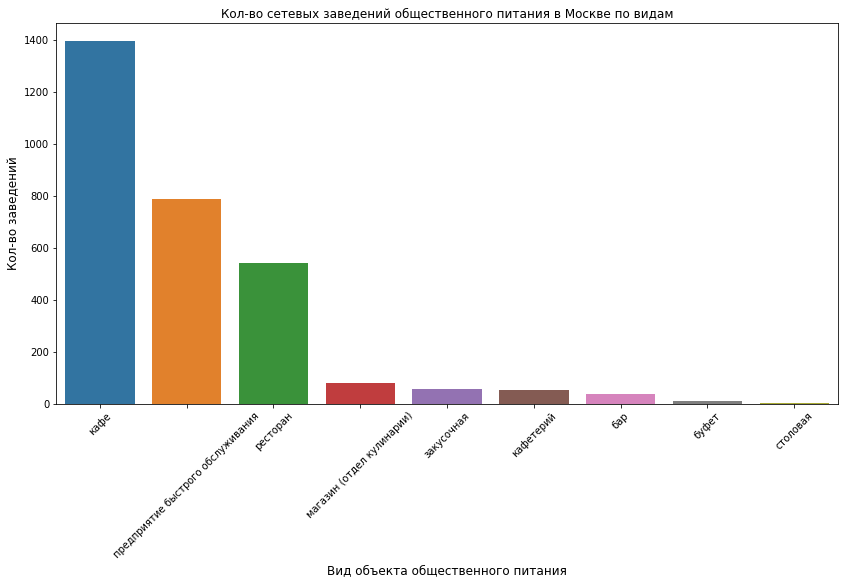

In [21]:
plt.figure(figsize=(14, 7)) 
ax = sns.barplot(x = 'object_type', y='сетевые',data=df_co.sort_values(by='сетевые',ascending=False))
ax.set_title('Кол-во сетевых заведений общественного питания в Москве по видам',fontsize=12)
ax.set_xlabel('Вид объекта общественного питания',fontsize=12)
ax.set_ylabel('Кол-во заведений',fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [22]:
df_co['доля'] = (df_co['сетевые']/(df_co['сетевые']+df_co['уникальные'])) * 100
df_co

,object_type,сетевые,уникальные,доля
0,бар,37,818,4.327485
1,буфет,11,566,1.906412
2,закусочная,56,293,16.045845
3,кафе,1396,4675,22.994564
4,кафетерий,52,343,13.164557
5,магазин (отдел кулинарии),78,195,28.571429
6,предприятие быстрого обслуживания,788,1110,41.517387
7,ресторан,543,1739,23.794917
8,столовая,3,2581,0.116099


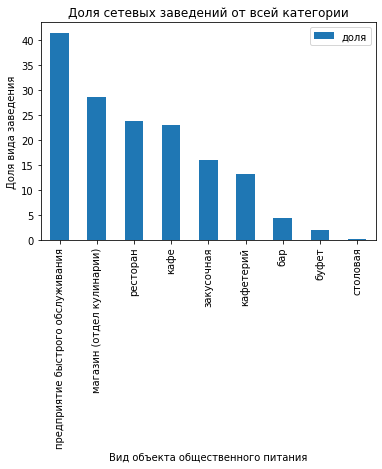

In [23]:
df_co[['object_type','доля']].sort_values(by='доля',ascending=False).plot(kind = 'bar',x='object_type')
plt.title('Доля сетевых заведений от всей категории')
plt.ylabel('Доля вида заведения') 
plt.xlabel('Вид объекта общественного питания')
plt.show()

In [24]:
#посчитаем долю сетевых заведений относительно их общего кол-ва и отфильтруем таблицу по новому столбцу
df_co['доля_сетевых_заведений'] = (df_co['сетевые']/df_co['сетевые'].sum())

In [25]:
df_co = df_co.sort_values(by='доля_сетевых_заведений',ascending=False)

In [26]:
df_co

,object_type,сетевые,уникальные,доля,доля_сетевых_заведений
3,кафе,1396,4675,22.994564,0.470985
6,предприятие быстрого обслуживания,788,1110,41.517387,0.265857
7,ресторан,543,1739,23.794917,0.183198
5,магазин (отдел кулинарии),78,195,28.571429,0.026316
2,закусочная,56,293,16.045845,0.018893
4,кафетерий,52,343,13.164557,0.017544
0,бар,37,818,4.327485,0.012483
1,буфет,11,566,1.906412,0.003711
8,столовая,3,2581,0.116099,0.001012


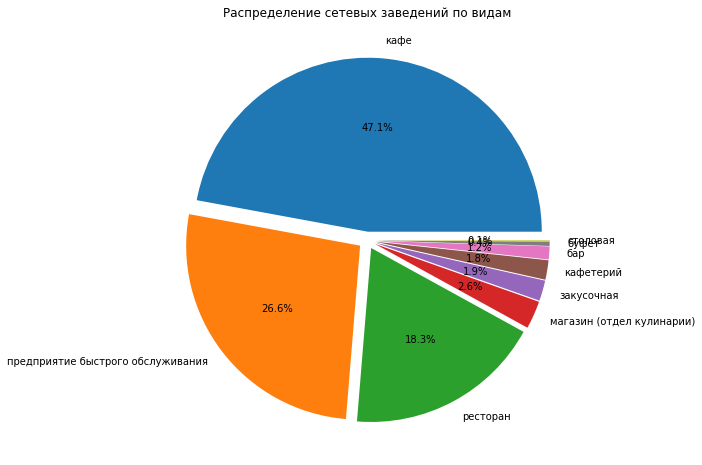

In [27]:
vals = df_co['доля_сетевых_заведений'].round(3)
labels = df_co['object_type']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, autopct='%1.1f%%', explode=explode)
ax.set_title('Распределение сетевых заведений по видам',fontsize=12)
plt.show()

##### Выводы:  
1. В количестве в Москве больше всего сетевых "кафе" (1396), на втором месте с большим отрывом "предприятия быстрого обсуживания" (788), на третьем сетевые "рестораны" (543). Прочие заведения имеют меньше 80 точек по городу;
2. Внутри группы сетевых заведений следующее распределение: 47.1% всех заведений - "предприятия быстрого обслуживания", 26.6% - "магазины(отдел кулинарии)",18.3% - "рестораны", прочие заведения занимают долю меньше 3% каждый.

#### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

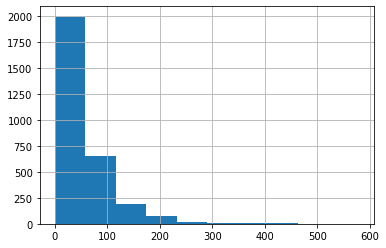

In [28]:
#изучим распределение посадочных мест в сетевых заведениях с целью принятия решение об использовании среднего/медианы
df.query('chain == "да"')['number'].hist()

In [29]:
#найдем среди сетевых заведений их кол-во и медианное кол-во посадочных мест, так как распределение далеко от нормального
df_on = df.query('chain == "да"').pivot_table(index=['object_name'],values='number',aggfunc=['count','median'])
df_on.columns = ['count','number_of_seats']

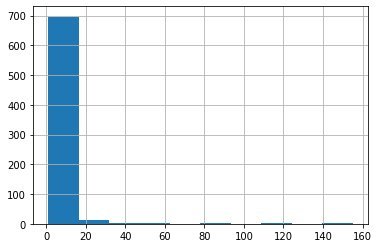

In [30]:
#определим кол-во заведений с одним названием 
df_on['count'].hist()

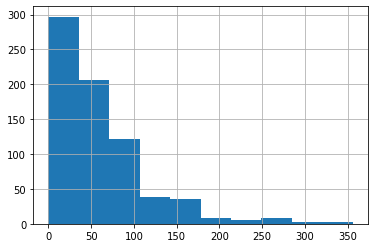

In [31]:
#определим кол-во посадочных мест в заведениях с одним названием
df_on['number_of_seats'].hist()

In [32]:
#рассмотрим кол-во посадочных мест в топ-20 заведений по кол-ву 
df_on1 = df_on.sort_values(by='count',ascending=False)
df_on1.head(20)

,count,number_of_seats
object_name,,
KFC,155,45.0
Шоколадница,141,50.0
Бургер Кинг,122,41.5
Макдоналдс,121,75.0
Домино'с Пицца,86,16.0
Теремок,84,21.0
Крошка Картошка,82,15.0
Милти,65,0.0
Суши Wok,61,6.0


In [33]:
#посмотрим на 20 заведений с самым большим кол-вом посадочных мест
df_on2 = df_on.sort_values(by='number_of_seats',ascending=False).head(20)
df_on2

,count,number_of_seats
object_name,,
Темпл Бар,1,356.0
БАКИНСКИЙ БУЛЬВАР,1,350.0
Чешская пивная «Козловица»,1,306.0
Кафе МУ-МУ,1,300.0
Ян Примус,1,300.0
Якитория и Ян Примус,1,282.0
Старина Миллер,1,280.0
Пражечка,1,266.0
Молли гвинз,1,250.0


In [34]:
#изучим распределение посадочных мест в сетевых заведениях по квантилям
df.query('chain == "да"').describe()

,id,number
count,2964.000000,2964.000000
mean,118096.469298,52.981107
std,67521.141932,57.152817
min,838.000000,0.000000
25%,59187.000000,15.000000
50%,129967.500000,40.000000
75%,176803.500000,72.000000
max,223318.000000,580.000000


##### Выводы:  
1. Кол-во посадочных мест у сетевых заведений варьируется в большинстве своем от 15 до 72, однако есть и рекордсмен с 580 местами или заведения совсем без посадки;  
2. В целом для сетевых заведений характерно небольшое кол-во точек с одним названием (до 20) и большим кол-вом посадочных мест (до 300);
3. Однако следует отметить и следующий тренд: если у заведения большое кол-во посадочных мест (около 200-300), то их будет 1-2 в городе, однако если у заведения много точек по городу, то количество посадочных мест в них будут сильно разниться, так например у Милти 65 точек в городе и в каждом нет посадочных мест, а вот Чайхона №1 имеет 42 точки и 100 посадочных мест всреднем на одно заведение.

#### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест?

In [35]:
#создадим сводную таблицу с видом сетевого заведения, его кол-вом и медианным кол-вом посадочных мест
df_otn = df.pivot_table(index=['object_type'],values='number',aggfunc=['count','median'])
df_otn.columns = ['count','number_of_seats']
df_otn = df_otn.sort_values(by='number_of_seats',ascending=False).reset_index()
df_otn

,object_type,count,number_of_seats
0,столовая,2584,103
1,ресторан,2282,80
2,бар,855,35
3,буфет,577,32
4,кафе,6071,30
5,кафетерий,395,6
6,предприятие быстрого обслуживания,1898,6
7,закусочная,349,0
8,магазин (отдел кулинарии),273,0


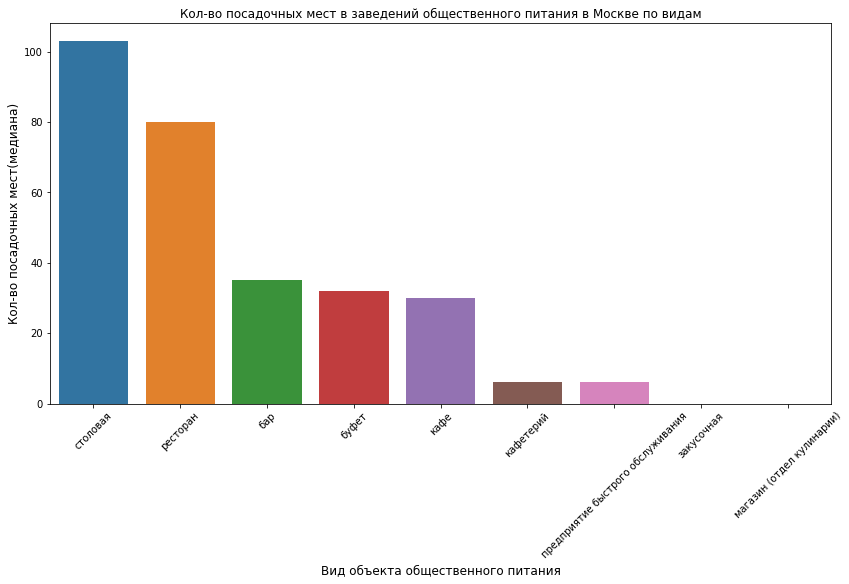

In [36]:
plt.figure(figsize=(14, 7)) 
ax = sns.barplot(x = 'object_type',y='number_of_seats',data=df_otn)
ax.set_title('Кол-во посадочных мест в заведений общественного питания в Москве по видам',fontsize=12)
ax.set_xlabel('Вид объекта общественного питания',fontsize=12)
ax.set_ylabel('Кол-во посадочных мест(медиана)',fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

##### Выводы:  
1. Самое большое кол-во посадочных мест среди заведений общественного питания встречается в столовых (103);
2. В ресторанах в среднем 80 посадочных мест, а вот в барах, кафе и буфетах 30-35;
3. В кафетеряих и предприятиях быстрого обслуживания 5-6 мест;
4. В закусочных и магазинах (отдел кулинарии) посадочных мест обычно не бывает вовсе.

#### Выделим в отдельный столбец информацию об улице из столбца address 

In [37]:
#при помощи метода split() отделим части импользуя запятые и пробел после нее; также наша часть должна содержать пробел и слова из списка
#список содержит улицы и слова синонимы, которые вручную ищем при помощи строчек кода ниже
for_address_column = ['улица','шоссе','переулок','бульвар','проезд','проспект','площадь','авеню','тупик','аллея','дорога','набережная','микрорайон','квартал','Зеленоград','деревня','поселение','линия','километр','территория','просек','посёлок']
def street(row):
    blocks = row['address'].split(', ')
    for block in blocks:
        words = block.split(' ')
        for word in words:
            if word in for_address_column:
                return block
df['street'] = df.apply(street, axis=1)

In [38]:
df['street'] = df['street'].fillna('неучтенные_названия')

In [39]:
#неучтенных синонимов слова "улица" нет
df.query('street == "неучтенные_названия"')

,id,object_name,chain,object_type,address,number,street


In [40]:
df

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,поселение Московский


##### Наблюдение:   
В исследуемом датасете предсталена не только Москва, как столичный центр, но и соседние города, деревни и прочее.

##### Постройм график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [41]:
#создадим датасет с топ-10 улиц по кол-ву заведений на них
df_street = df.pivot_table(index='street',values='id',aggfunc='count').sort_values(by='id',ascending = False).head(10).reset_index()
df_street

,street,id
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,172
4,Пресненская набережная,167
5,Варшавское шоссе,164
6,Ленинский проспект,148
7,поселение Сосенское,138
8,проспект Вернадского,128
9,Кутузовский проспект,114


In [42]:
df_street['street'].unique()

array(['город Зеленоград', 'проспект Мира', 'Профсоюзная улица',
       'Ленинградский проспект', 'Пресненская набережная',
       'Варшавское шоссе', 'Ленинский проспект', 'поселение Сосенское',
       'проспект Вернадского', 'Кутузовский проспект'], dtype=object)

In [48]:
#создадим переменную с файлом, где указаны улицы и районы
df2 = pd.read_csv('/content/mosgaz-streets.csv')
df2

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [49]:
#соеденим 2 датасета
df_street2 = pd.merge(df, df2, left_on = 'street',right_on='streetname', how = 'left')

In [50]:
df_streetf = df_street2.pivot_table(index=['street','area'],values='id',aggfunc='count').sort_values(by='id',ascending = False).reset_index().head(45)

In [51]:
df_a = df_streetf.groupby('area').agg({'street':pd.Series.nunique}).reset_index()
df_a2 = df_a.query('street == 2')
df_a2

,area,street
2,Донской район,2
3,Ломоносовский район,2
6,Обручевский район,2
12,Район Гагаринский,2
15,Район Крюково,2
19,Район Проспект Вернадского,2
25,Район Теплый Стан,2
26,Район Тропарево-Никулино,2


In [52]:
df_a2['area'].unique()

array(['Донской район', 'Ломоносовский район', 'Обручевский район',
       'Район Гагаринский', 'Район Крюково', 'Район Проспект Вернадского',
       'Район Теплый Стан', 'Район Тропарево-Никулино'], dtype=object)

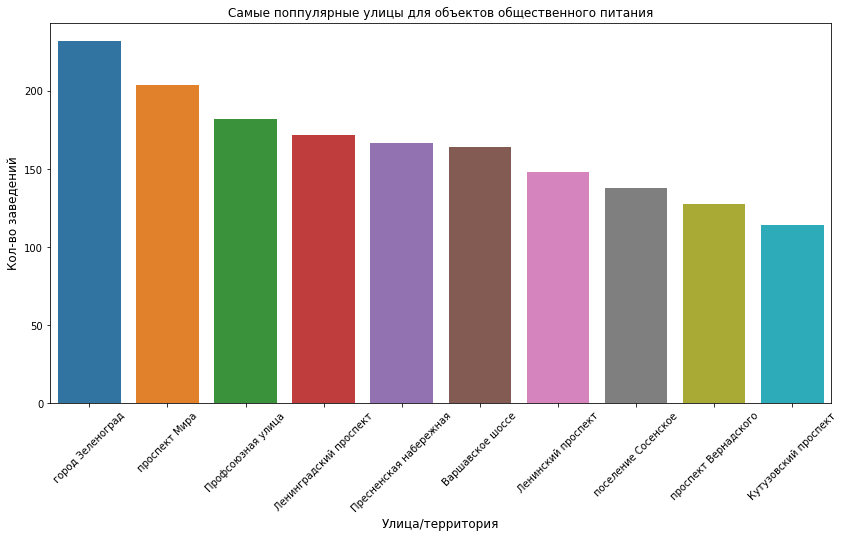

In [53]:
plt.figure(figsize=(14, 7)) 
ax = sns.barplot(x = 'street',y='id',data=df_street)
ax.set_title('Самые поппулярные улицы для объектов общественного питания',fontsize=12)
ax.set_xlabel('Улица/территория',fontsize=12)
ax.set_ylabel('Кол-во заведений',fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [54]:
df_streetf

,street,area,id
0,город Зеленоград,Район Матушкино-Савелки,232
1,город Зеленоград,Район Крюково,232
2,город Зеленоград,Панфиловский район,232
3,проспект Мира,Ярославский Район,204
4,проспект Мира,Район Свиблово,204
5,проспект Мира,Район Ростокино,204
6,проспект Мира,Район Марьина роща,204
7,проспект Мира,Алексеевский район,204
8,проспект Мира,Мещанский район,204
9,проспект Мира,Останкинский район,204


In [55]:
#найдем районы в которых больше всего заведений общественного питания
df_area = df_street2.pivot_table(index='area',values='id',aggfunc='count').sort_values(by='id',ascending=False).reset_index()
df_area.query('id>450')['area'].unique()

array(['Тверской район', 'Пресненский район', 'Басманный район',
       'Даниловский район', 'Мещанский район', 'Донской район',
       'Таганский район', 'Обручевский район', 'Район Замоскворечье',
       'Район Гагаринский'], dtype=object)

##### Вывод:  
1. При рассмотрении улиц и районов по  скоплению заведений общественного питания на первом месте располагается город Зеленоград. В нем 232 заведения. Данный город относится к райнам Матушкино-Савелки, Крюково и Панфиловский;
2. На втором месте по поппулярности проспект Мира - 204 заведения;
3. Одна улица/проспект и так далее входит в состав одного или нескольких районов, так например, Варшавское шоссе и Ленинский проспект каждый входят в состав 8 районов;
4. Рассматривая районы необходимо обратить внимание на районы из списка ниже, так как в каждый из них попадает минимум 2 поппулярные улицы.  
Список районов: 'Донской район', 'Ломоносовский район', 'Обручевский район','Район Гагаринский', 'Район Крюково', 'Район Проспект Вернадского','Район Теплый Стан', 'Район Тропарево-Никулино'  
5. В списке ниже представлены районы с самым большим кол-вом заведений общественного питания (более 450). В первом из них их более 1100 заведений.  
Список районов: 'Тверской район', 'Пресненский район', 'Басманный район','Даниловский район', 'Мещанский район', 'Донской район','Таганский район', 'Обручевский район', 'Район Замоскворечье','Район Гагаринский'

#### Найдем число улиц с одним объектом общественного питания

In [56]:
#выведем список улиц, на которых всего по 1 заведению общесвтенного питания
df_streetz = df.pivot_table(index='street',values='id',aggfunc='count').sort_values(by='id',ascending = False).reset_index()
df_streetz = df_streetz.query('id == 1')
streetz = df_streetz[['street']]
streetz

,street
1335,улица Достоевского
1336,улица Инессы Арманд
1337,Звонарский переулок
1338,1-я Миусская улица
1339,1-я Напрудная улица
...,...
1878,2-й Полевой переулок
1879,Ясногорская улица
1880,Малый Каретный переулок
1881,Яузский бульвар


In [57]:
#объеденим 2 датасета и определим районы у улиц с 1м заведением общественного питания
streetz2 = pd.merge(streetz, df2, left_on = 'street',right_on='streetname', how = 'inner')
streetz2

,street,streetname,areaid,okrug,area
0,улица Достоевского,улица Достоевского,19,ЦАО,Тверской район
1,улица Достоевского,улица Достоевского,78,СВАО,Район Марьина роща
2,улица Достоевского,улица Достоевского,16,ЦАО,Мещанский район
3,улица Инессы Арманд,улица Инессы Арманд,134,ЮЗАО,Район Ясенево
4,Звонарский переулок,Звонарский переулок,16,ЦАО,Мещанский район
...,...,...,...,...,...
560,2-й Полевой переулок,2-й Полевой переулок,26,ВАО,Район Сокольники
561,Ясногорская улица,Ясногорская улица,134,ЮЗАО,Район Ясенево
562,Малый Каретный переулок,Малый Каретный переулок,19,ЦАО,Тверской район
563,Яузский бульвар,Яузский бульвар,18,ЦАО,Таганский район


In [58]:
#выведем районы, в которых более 10 улиц с одним заведением общественного питания
strz2 = streetz2.pivot_table(index='area',values='street',aggfunc='count').sort_values(by='street',ascending=False).reset_index()
strz2.query('street >=10')['area'].unique()

array(['Таганский район', 'Район Хамовники', 'Басманный район',
       'Пресненский район', 'Тверской район', 'Район Арбат',
       'Район Марьина роща', 'Мещанский район', 'Район Сокольники',
       'Район Замоскворечье', 'Район Лефортово', 'Район Соколиная Гора',
       'Даниловский район', 'Красносельский район', 'Район Богородское',
       'Район Якиманка'], dtype=object)

##### Вывод:  
1. В Москве представлено 548 улиц, на которых всего 1 заведение общественного питания; в основном это маленькие улицы, которые располагаются внутри одного района города;
2. Эти улицы разбросаны по 101 району города;  
3. При этом более 10  улиц с одним заведением общепита представлено  в районах из списка ниже.  

Список районов: 'Таганский район', 'Район Хамовники', 'Басманный район',
       'Пресненский район', 'Тверской район', 'Район Арбат',
       'Район Марьина роща', 'Мещанский район', 'Район Сокольники',
       'Район Замоскворечье', 'Район Лефортово', 'Район Соколиная Гора',
       'Даниловский район', 'Красносельский район', 'Район Богородское',
       'Район Якиманка

#### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

In [59]:
#создадим сводную таблицу с кол-вом заведений по улицам и кол-вом посадочных мест, отсортируем список по кол-ву заведений
df_streetn = df.pivot_table(index='street',values=['id','number'],aggfunc={'id':'count','number':'median'}).sort_values(by='id',ascending=False)
di = df_streetn.query('id>100')
di

,id,number
street,,
город Зеленоград,232,52.5
проспект Мира,204,46.5
Профсоюзная улица,182,24.5
Ленинградский проспект,172,40.0
Пресненская набережная,167,30.0
Варшавское шоссе,164,30.0
Ленинский проспект,148,45.0
поселение Сосенское,138,15.0
проспект Вернадского,128,40.0


In [60]:
di.describe()

,id,number
count,13.000000,13.000000
mean,151.538462,32.961538
std,39.915777,12.482424
min,102.000000,10.000000
25%,114.000000,25.000000
50%,148.000000,30.000000
75%,172.000000,40.000000
max,232.000000,52.500000


#####  Выводы:  
1. На улицах с большим кол-вом заведений (более 100) посадочных мест не много, в среднем их 30;
2. Стоит обратить внимание, что на Ходынском бульваре 102 заведения, на которые приходится всреднем всего 10 посадочных мест, а 
в поселении Сосенское - 15 мест;  
3. Больше всего заведений в городе Зеленограде, там же и больше всего посадочных мест в среднем (53)

###  Общий вывод  - рекомендации для открытия заведения общественного питания, в котором обслуживают Гостей роботы:  
 1. **Вид заведения - кафе.** Так как заведение - нестандартное, то необходимо захватить самый массовый сегмент рынка с целью снижения рисков вложения денежных средств в проект, отсюда делаем вывод, что в заведении будет не высокий средний чек. Данным форматом является кафе. Обычно в них труд официанта  не высококваллифицирован, а значит его будет проще заменить на робота.  
  *Неподходящие варианты заведения*: ресторан и кафе быстрого обслуживания, так как в первом высока значимость атмосферы, которую создает в том числе и обслуживающий персонал, роботы на текущем уровне своего развития не могут заменить человека в этом аспекте; в кафе же быстрого обслуживания практически нет системы обслуживания гостей: там есть киоски самообслуживания и мобильные приложения для заказа, что скорее является конкурентом физическому роботу-официанту;  
    
 2. **Кол-во посадочных мест - от 40 (норма для данного формата) до 100**. Особенностью заведения являются роботы, то есть Гости будут редко брать еду с собой или заказывать доставку. Они будут приходить за продукцией - едой, а также 'общением' с роботами-официантами.   То есть велика вероятность, что Гости будут долго засиживаться в заведении. В таком случае для увеличения выручки необходимо выставить как можно больше посадочных мест с возможностью свободного перемещения между ними роботов и Гостей; а также возможно ограничить Гостей на визит (например не более 1-2 часов).    
*Неподходящий вариант посадки* - более 100, так как это влечет за собой высокие риски закрытия заведения введу глобальной пандемии, а также то, что сами Гости уже не лояльно относятся к большому скоплению людей. Также большое кол-во посадочных мест = высокие затраты на аренду, как на ежемесячный платеж;  
  
 3. **Локация - город Зеленоград или поппулярные районы Москвы** с точки зрения наличия на них других заведений общепита. Зеленоград - российская Силиконовая долина, поэтому ресторан с роботами вполне впишется в общий антураж города. Здесь необходимо открываться только в том случае, если будут выгодные условия по аренде, возможные коллаборации с местными производствами и научными лабораториями, где также могут быть использованы наши роботы в часы и дни низкой нагрузки в кафе.  
  В Москве для открытия лучше всего подойдут 'Тверской район', 'Пресненский район', 'Басманный район','Даниловский район', Мещанский район', 'Донской район','Таганский район', 'Обручевский район', 'Район Замоскворечье','Район Гагаринский'.
Необходимо учесть, что наши Гости скорее всего будут передвигаться на общественном транспорте, поэтому желательна пешая доступность от метро или крупного траспортного узла. 
  
 4. **Возможность развития сети.** Необходимо экспериментировать с открытием заведений разной направленности: преимущественного для аудитории родителей с детьми ( тут нужна детская комната, особенное меню и определенные настройки у роботов, возможно наличие робо-няни); турристические точки (возле вокзалов, на прогулочных улицах, возле станций метро); формат закусочных в технологических вузах или рядом с ними. Самые успешные форматы можно множить и превращать в небольшую сеть. Важно, чтобы роботы способствовали возвращению Гостей вновь и вновь, иначе сети не выжить даже в масштабах столицы.

Презентация для инвесторов: https://drive.google.com/file/d/1EfTYBNxXLTXVMaNPaejioYFJXKc2HWd_/view?usp=sharing